In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from ast import literal_eval 
import spacy

nlp = spacy.load("en_core_web_sm")


In [72]:
df = pd.read_csv("data\MovieSummaries\movie.metadata.tsv", sep='\t',header=None, names=['Wikipedia_ID','Freebase_ID','name','release_date','revenue','runtime','languages','countries','genres'])

sm = pd.read_csv("data\MovieSummaries\extracted.csv")

In [73]:
#sum["ethnicity"] = [extract_nat(group,nlp) for group in df["summary"].apply(str)]
#1h30 approx.

#sum.to_csv('data\MovieSummaries\extracted.csv')
#sum["ethnicity"]

In [74]:
display(sm)
display(df)

,Wikipedia_ID,Summary,ethnicity
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",[]
1,31186339,The nation of Panem consists of a wealthy Capi...,['District 11']
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"['Induchoodan', 'Induchoodan', 'Induchoodan', ..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",['Brainy']
4,595909,Seventh-day Adventist Church pastor Michael Ch...,['the Outback']
...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...",['Muslim']
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...",['Russian']
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,['American']
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",['Bengali']


,Wikipedia_ID,Freebase_ID,name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [75]:
# Harmonize dates for plotting
df['release_year'] = pd.to_datetime(df['release_date'],errors='coerce')

# Create a new column 'year' to store the year information
df['release_year'] = df['release_year'].dt.year

# For entries with missing dates, fill 'year' with the year information
df['release_year'].fillna(df['release_date'], inplace=True)

df.drop(columns=['release_date'], inplace=True)

df = pd.merge(df, sm, on='Wikipedia_ID', how='left')

df = df.dropna(subset=['Summary','release_year'])

# Reformat remaining dates
df['release_year'] = df['release_year'].apply(str)
df['release_year'] = df['release_year'].str[:4].astype(int)

display(df)

,Wikipedia_ID,Freebase_ID,name,revenue,runtime,languages,countries,genres,release_year,Summary,ethnicity
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,"Set in the second half of the 22nd century, th...","['Mars', 'Martian', 'Martian', 'Martian']"
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,A series of murders of rich young women throug...,['Indian']
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,"Eva, an upper class housewife, becomes frustra...",[]
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",2002,"Every hundred years, the evil Morgana returns...",['Merlin']
12,6631279,/m/0gffwj,Little city,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",1997,"Adam, a San Francisco-based artist who works a...",[]
...,...,...,...,...,...,...,...,...,...,...,...
81733,23851782,/m/06_vb43,The Ghost Train,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",1941,{{plot}} The film opens with a Great Western e...,"['Julia', 'Nazi', 'British']"
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,Two former National Oceanic Atmospheric Admini...,[]
81737,34980460,/m/0g4pl34,Knuckle,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,{{No plot}} This film follows 12 years in the ...,['Irish']
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,"The story takes place in the year 2092,The Sup...","['Earth', 'Marduk', 'Earth']"


In [76]:
df['release_year'] = df['release_year'].apply(str)
df['release_year'] = df['release_year'].str[:4].astype(int)
df

,Wikipedia_ID,Freebase_ID,name,revenue,runtime,languages,countries,genres,release_year,Summary,ethnicity
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,"Set in the second half of the 22nd century, th...","['Mars', 'Martian', 'Martian', 'Martian']"
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,A series of murders of rich young women throug...,['Indian']
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,"Eva, an upper class housewife, becomes frustra...",[]
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",2002,"Every hundred years, the evil Morgana returns...",['Merlin']
12,6631279,/m/0gffwj,Little city,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",1997,"Adam, a San Francisco-based artist who works a...",[]
...,...,...,...,...,...,...,...,...,...,...,...
81733,23851782,/m/06_vb43,The Ghost Train,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",1941,{{plot}} The film opens with a Great Western e...,"['Julia', 'Nazi', 'British']"
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,Two former National Oceanic Atmospheric Admini...,[]
81737,34980460,/m/0g4pl34,Knuckle,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,{{No plot}} This film follows 12 years in the ...,['Irish']
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,"The story takes place in the year 2092,The Sup...","['Earth', 'Marduk', 'Earth']"


In [77]:
df.Summary[0]

'Set in the second half of the 22nd century, the film depicts Mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. The Martian society has become largely matriarchal, with women in most positions of authority. The story concerns a police officer, Melanie Ballard , second in command of a small team alongside Sergeant Jericho  sent to pick up and transport a prisoner named Desolation Williams . Arriving at the remote mining town where Williams is being held, Ballard finds virtually all of the people missing. She learns that the miners had discovered an underground doorway created by an ancient Martian civilization. When the door was opened it released "ghosts," disembodied spirits which possessed the miners. Violence ensues, as the possessed miners commit horrific acts of death and destruction, as well as self-mutilation. With their team leader Helena Bradock  murdered, Ballard must fight off the attacking miners, escape t

In [78]:
df['Summary']

0        Set in the second half of the 22nd century, th...
3        A series of murders of rich young women throug...
4        Eva, an upper class housewife, becomes frustra...
6        Every hundred years, the evil Morgana  returns...
12       Adam, a San Francisco-based artist who works a...
                               ...                        
81733    {{plot}} The film opens with a Great Western e...
81736    Two former National Oceanic Atmospheric Admini...
81737    {{No plot}} This film follows 12 years in the ...
81739    The story takes place in the year 2092,The Sup...
81740    The movie is about a teenage girl who loves ho...
Name: Summary, Length: 39586, dtype: object

In [79]:
def is_token_allowed(token):
    return bool(
        token
        and str(token).strip()
        and token.pos_ in ["ADJ" ,"PROPN","NOUN"]
        and not token.is_stop
        and not token.is_punct
    )
def preprocess_token(token):
    return token.lemma_.strip().lower()
def preprocess(summary):
    # Process the text with spaCy
    doc = nlp(summary)
    return [preprocess_token(token) for token in doc if is_token_allowed(token)]

In [80]:
list= []
for i in range(100):
    list.append(preprocess(sm.Summary[i]))
print(list)

[['shlykov', 'taxi', 'driver', 'lyosha', 'saxophonist', 'bizarre', 'love', 'hate', 'relationship', 'prejudice', 'different'], ['nation', 'panem', 'wealthy', 'capitol', 'poor', 'district', 'punishment', 'past', 'rebellion', 'district', 'boy', 'girl', 'age', 'lottery', 'annual', 'hunger', 'games', 'tribute', 'death', 'arena', 'sole', 'survivor', 'fame', 'wealth', 'reaping', 'year', 'old', 'primrose', 'everdeen', 'district', 'old', 'sister', 'katniss', 'volunteer', 'place', 'peeta', 'mellark', 'baker', 'son', 'katniss', 'bread', 'district', 'tribute', 'katniss', 'peeta', 'capitol', 'drunk', 'mentor', 'victor', 'haymitch', 'abernathy', 'career', 'tribute', 'special', 'academy', 'tv', 'interview', 'caesar', 'flickerman', 'peeta', 'love', 'katniss', 'outraged', 'ploy', 'audience', 'support', 'sponsor', 'games', 'gift', 'food', 'medicine', 'tool', 'peeta', 'games', 'half', 'tribute', 'minute', 'katniss', 'haymitch', 'advice', 'melee', 'supply', 'weapon', 'structure', 'cornucopia', 'peeta', 'u

In [81]:
list= []
def extract_nat(text,nlp):
    doc = nlp(str(text))
    return [ent.text for ent in doc.ents if ent.label_ in["NORP","LOC"]]

for i in range(100):
    list.append(extract_nat(sm.Summary[i],nlp))
print(list)


[[], ['District 11'], ['Induchoodan', 'Induchoodan', 'Induchoodan', 'Induchoodan'], ['Brainy'], ['the Outback'], [], [], ['Jewish'], [], [], ['Hispanic', 'Caucasian'], [], [], ['American', 'Jews', 'British', 'Jewish', 'British', 'British', 'Danish-Jewish', 'Zionist', 'Arab', 'Jewish', 'Zionist', 'Akiva', 'Nazis', 'Jewish', 'Jewish', 'British', 'Jewish', 'Mount Tabor', 'Lebanese', 'British', 'Arab', 'Arab', 'Arab', 'Arab', 'Jewish', 'Jews', 'Arabs'], [], [], [], [], ['Italian', 'Italian'], ['Vietnamese', 'Vietnamese'], ['English', 'Australian', 'Africa', 'Italian', 'Germans'], [], ['Catholic'], ['West Point'], ['Africans', 'African', 'African'], ['Madhav'], ['Govinda', 'Swaroop', 'Swaroop', 'Govinda', 'Swaroop', 'Swaroop', 'Swaroop', 'Swaroop', 'Swaroop', 'Swaroop', 'Govinda', 'Govinda', 'Govinda', 'Shambu'], ['Stooges'], ['Patel'], ['Indian'], ['Nazirite', 'Philistines', 'Delilah', 'Philistines', 'Philistines'], ['Russian'], [], [], ['Europe'], ['Indians', 'Indians'], ['Amici'], [], []

In [82]:
df[['release_year','ethnicity']].to_csv('data\MovieSummaries\year_ethnicity.csv',index = None)
df = df[['release_year','ethnicity']]
df

,release_year,ethnicity
0,2001,"['Mars', 'Martian', 'Martian', 'Martian']"
3,1987,['Indian']
4,1983,[]
6,2002,['Merlin']
12,1997,[]
...,...,...
81733,1941,"['Julia', 'Nazi', 'British']"
81736,2011,[]
81737,2011,['Irish']
81739,1992,"['Earth', 'Marduk', 'Earth']"


In [83]:
cl = df.dropna(subset=['release_year', 'ethnicity']).loc[lambda x: x['ethnicity'].apply(lambda y: len(eval(y)) > 0)]
cl

,release_year,ethnicity
0,2001,"['Mars', 'Martian', 'Martian', 'Martian']"
3,1987,['Indian']
6,2002,['Merlin']
13,1989,"['French', 'Greek']"
17,1964,"['Earth', 'Irish', 'the East End of']"
...,...,...
81726,1993,"['Haines', 'Haines', 'Haines', 'Haines']"
81732,2010,['Eleni']
81733,1941,"['Julia', 'Nazi', 'British']"
81737,2011,['Irish']


In [84]:

def plot_occurrences(df,occ_list,ethnicity):
    data = df.copy()
    def count_words(word_list):
        return [word.lower() in occ_list for word in word_list].count(True)

    # Apply the function to count Germany-related words for each row
    data[ethnicity] = data['ethnicity'].apply(lambda x: count_words(literal_eval(x)))

    # Group by release year and sum the counts
    counts_by_year = data.groupby('release_year')[ethnicity].sum()

    # Plot the results
    plt.plot(counts_by_year.index, counts_by_year.values)
    plt.title('Number of '+ethnicity+'-related Words Over the Years')
    plt.xlabel('Release Year')
    plt.ylabel('Number of '+ethnicity+'-related Words')
    plt.show()

In [85]:
def count_w(word_list):
    occ_list = ['American','american','jew']
    return [word.lower() in occ_list for word in word_list].count(True)


cl['ethnicity'].apply(lambda x: count_w(literal_eval(x))).sum()

2781

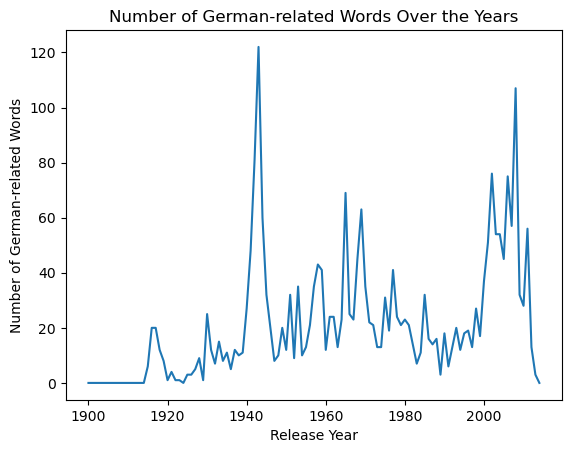

In [86]:
occ_list = ['germany','german','germans']
ethnicity = 'German'
df=df[df['release_year']>=1900]
plot_occurrences(df,occ_list,ethnicity)


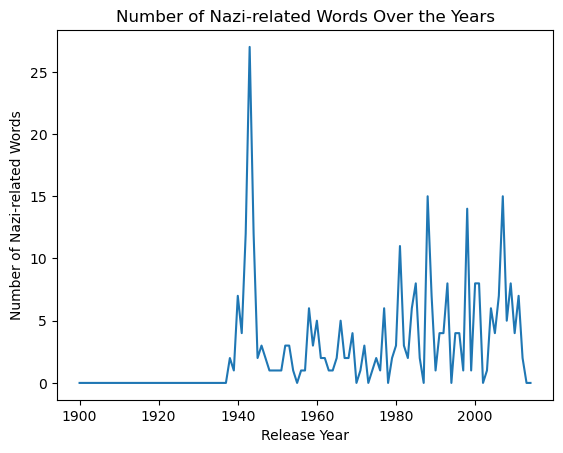

In [87]:
occ_list = ['nazis','nazis','reich','ss']
ethnicity = 'Nazi'
df=df[df['release_year']>=1900]
plot_occurrences(df,occ_list,ethnicity)

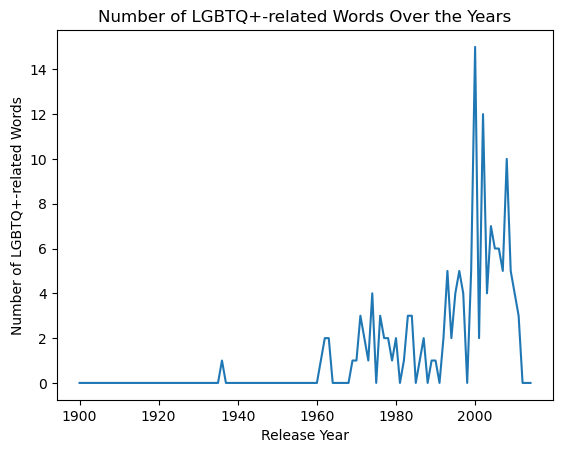

In [88]:
lgbtq_keywords = [
    "gay", "lesbian", "bisexual", "transgender", "queer",
    "homosexual",
    "same-sex", "same-gender",
    "non-binary", "genderqueer",
    "drag queen", "drag king",]
ethnicity = 'LGBTQ+'
plot_occurrences(df,lgbtq_keywords,ethnicity)

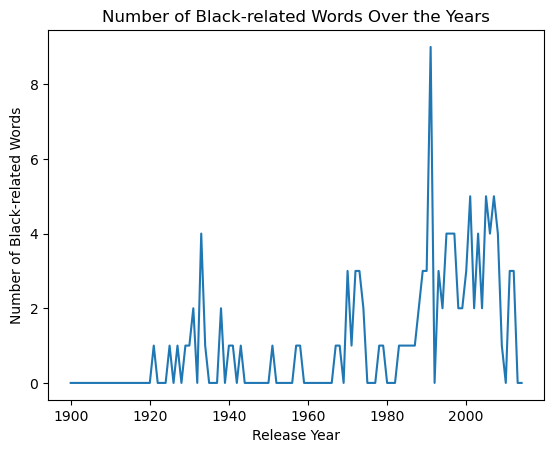

In [89]:
african_american_keywords = [
    "african american",
    "black",
    "afro-american",
    "negro",
    "nigger"
    "afro",
]
ethnicity = 'Black'
plot_occurrences(df,african_american_keywords,ethnicity)

In [156]:
def plot_occurrences2(df,eth,ethnicities):
    data = df.copy()
    fig, ax = plt.subplots()
    for et in ethnicities:
        index= eth[eth['Ethnicity'] == et].index[0]
        occ_list = literal_eval(eth.at[index,'Keywords'])
        def count_words(word_list):
            return [word.lower() in occ_list for word in word_list].count(True)

        # Apply the function to count Germany-related words for each row
        data[et] = data['ethnicity'].apply(lambda x: count_words(literal_eval(x)))

        # Group by release year and sum the counts
        counts_by_year = data.groupby('release_year')[et].sum()
        # Plot the results
        ax.plot(counts_by_year.index, counts_by_year.values, label=et)
    ax.legend()
    plt.title('Number of ethnicities-related Words Over the Years')
    plt.xlabel('Release Year')
    plt.ylabel('Number of ethnicities-related Words')
    plt.show()


In [147]:
data = {
    "Ethnicity": ["French", "German", "Italian", "Spanish", "Chinese", "Japanese", "Indian", "Russian", "Mexican", "Brazilian", "Canadian", "Australian", "African", "Middle Eastern", "Scandinavian"],
    "Keywords": [
        ["french", "france", "paris", "parisian", "parisians", "frenchman", "frenchmen", "frenchwoman", "frenchwomen"],
        ["german", "germany", "berlin", "bavarian", "germans", "berliners"],
        ["italian", "italy", "rome", "venetian", "italians", "romans"],
        ["spanish", "spain", "madrid", "barcelona", "spaniards", "madrilenian", "barcelonians"],
        ["chinese", "china", "beijing", "shanghai", "chinese person", "chinese people"],
        ["japanese", "japan", "tokyo", "osakan", "japanese person", "japanese people"],
        ["indian", "india", "delhi", "mumbai", "indians", "delhites", "mumbaikars"],
        ["russian", "russia", "moscow", "stpetersburg", "russians", "moscovites", "petersburgers"],
        ["mexican", "mexico", "mexico city", "mexicans", "mexico city dwellers"],
        ["brazilian", "brazil", "rio", "saopaulo", "brazilians", "cariocas", "paulistanos"],
        ["canadian", "canada", "toronto", "vancouver", "canadians", "torontonians", "vancouverites"],
        ["australian", "australia", "sydney", "melbourne", "australians", "sydneysiders", "melburnians"],
        ["african", "africa", "nigerian", "kenyan", "africans", "nigerians", "kenyans"],
        ["middleeastern", "middleeast", "arab", "israeli", "middle eastern", "arabs", "israelis"],
        ["scandinavian", "scandinavia", "swedish", "norwegian", "scandinavians", "swedes", "norwegians"]
    ]
}

eth = pd.DataFrame(data)
eth['Keywords'] = eth['Keywords'].apply(str)
eth['Ethnicity'] = eth['Ethnicity'].apply(str)
display(eth)

,Ethnicity,Keywords
0,French,"['french', 'france', 'paris', 'parisian', 'par..."
1,German,"['german', 'germany', 'berlin', 'bavarian', 'g..."
2,Italian,"['italian', 'italy', 'rome', 'venetian', 'ital..."
3,Spanish,"['spanish', 'spain', 'madrid', 'barcelona', 's..."
4,Chinese,"['chinese', 'china', 'beijing', 'shanghai', 'c..."
5,Japanese,"['japanese', 'japan', 'tokyo', 'osakan', 'japa..."
6,Indian,"['indian', 'india', 'delhi', 'mumbai', 'indian..."
7,Russian,"['russian', 'russia', 'moscow', 'stpetersburg'..."
8,Mexican,"['mexican', 'mexico', 'mexico city', 'mexicans..."
9,Brazilian,"['brazilian', 'brazil', 'rio', 'saopaulo', 'br..."


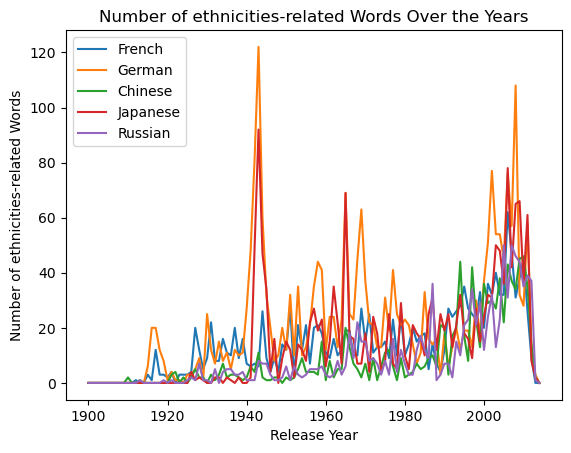

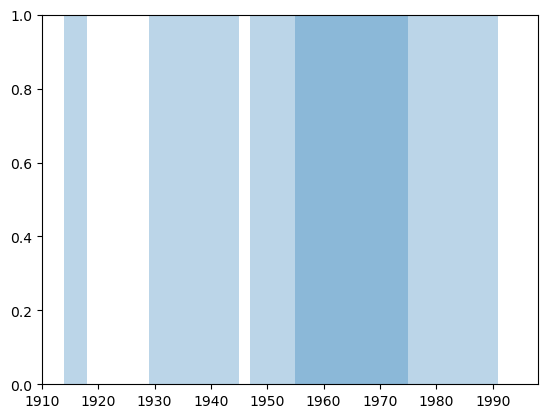

In [157]:

highlight_dates = [(1914,1918,'WWI'),(1929,1939,'Great depression'),(1939,1945,'WWII'),(1947,1991,'Cold war'),(1955,1975,"Vietnam War"),(1989,1989,'Berlin wall end'),(1994,1994,'apartheid end'),(1991,1991,'USSR end')]


for date in highlight_dates:
    highlight_start=date[0]
    highlight_end=date[1]
    plt.axvspan(
    highlight_start,
    highlight_end,
    alpha=0.3,
    label=date[2]
    )




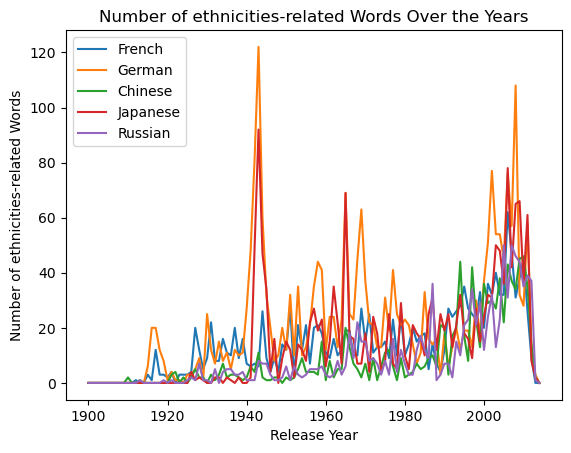

In [158]:
plot_occurrences2(df,eth,['French', 'German', 'Chinese', 'Japanese', 'Russian'])

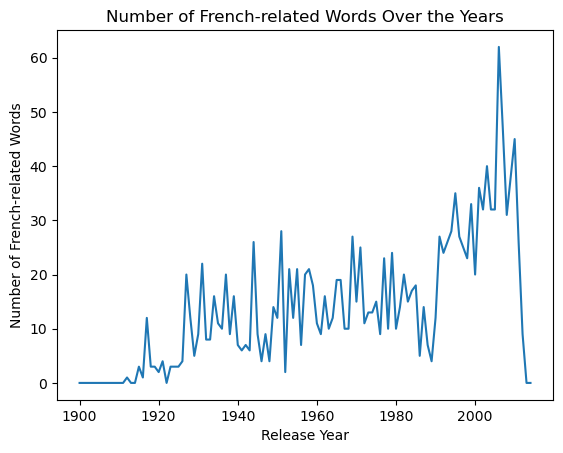

In [145]:
et='French'
index = eth[eth['Ethnicity'] == 'French'].index[0]
literal_eval(eth.at[index,'Keywords'])
occ_list=literal_eval(eth.at[index,'Keywords'])
plot_occurrences(df,occ_list,et)


In [165]:
data = {
    'Ethnicity': ['Nazi','Jewish','Islamic','LGBTQ'],
    'Keywords': [
        ['nazi', 'nazis'],
        ['jewish', 'jews','jew','ashkenazy'],
        ['islamic', 'muslim', 'islam','muslims'],
        ['pansexual', 'homo', 'homosexual', 'queer', 'gay', 'lesbian', 'bisexual', 'transgender']
    ]
}

eth2 = pd.DataFrame(data)
eth2['Keywords'] = eth2['Keywords'].apply(str)
eth2['Ethnicity'] = eth2['Ethnicity'].apply(str)
ethmerged= pd.concat([eth,eth2],ignore_index=True)
display(ethmerged)

,Ethnicity,Keywords
0,French,"['french', 'france', 'paris', 'parisian', 'par..."
1,German,"['german', 'germany', 'berlin', 'bavarian', 'g..."
2,Italian,"['italian', 'italy', 'rome', 'venetian', 'ital..."
3,Spanish,"['spanish', 'spain', 'madrid', 'barcelona', 's..."
4,Chinese,"['chinese', 'china', 'beijing', 'shanghai', 'c..."
5,Japanese,"['japanese', 'japan', 'tokyo', 'osakan', 'japa..."
6,Indian,"['indian', 'india', 'delhi', 'mumbai', 'indian..."
7,Russian,"['russian', 'russia', 'moscow', 'stpetersburg'..."
8,Mexican,"['mexican', 'mexico', 'mexico city', 'mexicans..."
9,Brazilian,"['brazilian', 'brazil', 'rio', 'saopaulo', 'br..."


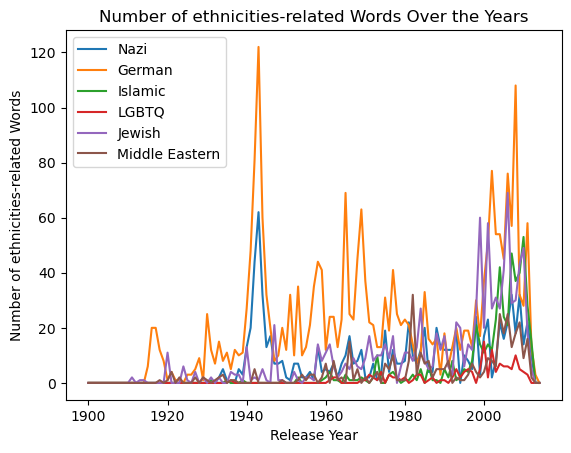

In [168]:
plot_occurrences2(df,ethmerged,['Nazi', 'German', 'Islamic', 'LGBTQ', 'Jewish',"Middle Eastern"])